In [43]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [44]:
from resources.conv_learner import *
PATH = "datasets/yeast_v2/"
os.makedirs(PATH,exist_ok=True)

In [45]:
import os
from pathlib import Path
from os.path import basename

In [46]:
test_dir = "datasets/yeast_v2/"
data_path = Path(test_dir)

In [47]:
# calculate
test_dirs , train_dirs = [], []

for ds_dir in data_path.iterdir():
    if '.DS_Store' not in str(ds_dir):
        for class_dir in ds_dir.iterdir():
            if '.DS_Store' not in str(class_dir):
                if 'test' in str(class_dir): test_dirs.append(class_dir)
                elif 'train' in str(class_dir): train_dirs.append(class_dir)

In [51]:
import numpy as np
means = {} # class_name: (mean)
stdvs = {} # class_name: (stdev)
stats = {}

class_dirs = zip(test_dirs,train_dirs)
for test, train in class_dirs:
    class_images = []
    class_name = basename(str(test).split('/')[-1]) #adding "basename" function avoids saving entire path; kinda nicer
    class_images = []
    for dir_ in [test,train]:
        # read from each dir and append to the images
        for file in dir_.iterdir():
            image = tifffile.imread(str(file))
            if image.shape[-1] == 200 and image.shape[-2] ==200:
                class_images.append(image)
            else:
                os.remove(str(file)) # get rid of the non square images
                print(f"removed file: {str(file)}")
    # calc std
    print(class_name)
    means[class_name] = np.mean(class_images, axis=(0,2,3))
    stdvs[class_name] = np.std(class_images, axis=(0,2,3))
    
    mean, stdev = np.mean(class_images, axis=(0,2,3))/65535, np.std(class_images, axis=(0,2,3))/65535
    stats[class_name] = (mean, stdev)

mfb1KO
WT


In [49]:
stats.keys()

dict_keys(['mfb1KO', 'WT'])

In [52]:
print(stats)

{'mfb1KO': (array([0.02111, 0.00453]), array([0.00149, 0.00161])), 'WT': (array([0.0211, 0.0045]), array([0.00149, 0.00129]))}


In [19]:
classes = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
# stats = (np.array([0.02171638, 0.00451]), np.array([0.0016155,  0.00146062])) #calculated for yeast_v2

C1 = (np.array([521.95544, 520.43242, 522.00262, 517.82433]), 
         np.array([48.37305, 47.58622, 49.22678, 47.79874]))

C2= (np.array([310.77446, 311.95407, 315.8627, 310.53787]), 
         np.array([95.64728, 102.40188, 110.9711, 100.2844]))



stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [20]:
def get_data(sz,bs):
#     tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [21]:
bs=140

In [22]:
data = get_data(200,4)

In [23]:
x,y=next(iter(data.trn_dl))

ValueError: operands could not be broadcast together with shapes (200,200,2) (3,) 

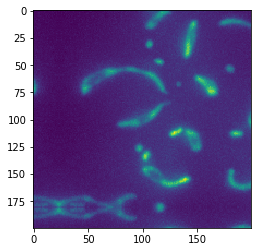

In [8]:
plt.imshow(data.trn_ds.denorm(x)[3,:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

In [9]:
lr=1e-5

In [13]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [14]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 2), data)

In [15]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 20, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 1020)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 200, 200]),
                           ('output_shape', [-1, 40, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 20040)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 200, 200]),
                           ('output_shape', [-1, 80, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 80080)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 200, 200]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
 

In [16]:
%time learn.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                                                                                                                                                    
    0      0.735049   0.71461    0.485714  
    1      0.714636   0.696415   0.485714                                                                                                                                                                                                    
    2      0.698167   0.686474   0.485714                                                                                                                                                                                                    
    3      0.684538   0.681277   0.485714                                                                                                                                                                                                    
    

[array([0.6654]), 0.4857142857142857]

In [ ]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)